# Notebook Context

This is 4 of 6 Jupyter Notebooks associated with the used car project.

Data cleaning, feature engineering and merging of data sources are performed before presenting some exploratory data analysis. This notebook takes input data from [01_AutoTrader_scrape](https://github.com/rgdavies92/used-car-value/blob/main/01_AutoTrader_scrape.ipynb), [02_Carsized_scrape](https://github.com/rgdavies92/used-car-value/blob/main/02_Carsized_scrape.ipynb) and [03_GeoCoding](https://github.com/rgdavies92/used-car-value/blob/main/03_GeoCoding.ipynb).

In [1]:
# Import packages 

import pandas as pd
import glob
import numpy as np
import re
import regex
import time
import random
import scipy.stats as stats
import itertools
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import requests
import cloudscraper
from bs4 import BeautifulSoup
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import and clean cars

The scraped cars will be cleaned in four different batches.

* Used cars - not electric
    * Starting with 374854 cars and ending with 373912
* Used cars - electric
    * Starting with 4887 cars and ending with 4740
* New cars - not electric
    * Starting with 18906 cars and ending with 18890
* New cars - electric
    * Starting with 2816 cars and ending with 2764

The cleaning method is very similar for each batch, with differences occurring in the way engine size is handled for electric/non-electric vehicles. 

I have heavily commented the code for the *Used cars - not electric* cleaning section with a slightly liter code commenting approach on the subsequent 3 batches as the method is very repetitive. If ever the approach is unclear, I would suggest checking the corresponding cleaning stage in the *Used cars - not electric* section.

## Used cars - not electric

In [2]:
# Import all detailed files and make cars df, including year 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed'

li=[]

# For each year between 1990 and 2021, import each used car file with glob package
for year in range(1990,2022):
    year_files = glob.glob(path + f"/*{year}*used.csv")
    for filename in year_files:
        # Make it into a dataframe
        df = pd.read_csv(filename, index_col=None, header=0 )
        # Assign YR variable - this was only possible because of the way in which they were gathered
        df['YR'] = year
        # Drop diplicates within a file - highly possible because of the AutoTrader searching method implemented
        df.drop_duplicates(subset=['link'], keep='first', inplace=True)
        # Append to a list of dataframes
        li.append(df)

# Concatenate all dataframes and drop duplicates again
ucars = pd.concat(li, axis=0, ignore_index=True)
ucars.drop_duplicates(subset=['link'], keep='first', inplace=True)
print('DataFrame shape:',ucars.shape)

DataFrame shape: (374854, 20)


In [3]:
# Clean cars.body 

# This block of code uses label encoder to transform the body variable, then imputs the missing body data
# with the modal value for the specified car name. 

# In hindsight there may be a better way to do this without using label encoder but it isn't broken so I won't
# try to fix it here. 

#Create df of cars will null body
nabody = ucars[ucars['body'].isnull()].copy()

#Encode body column but don't overwrite
to_encode = ['body']
cars_e = ucars.copy()
for col in to_encode:
    le = LabelEncoder()
    cars_e[col] = le.fit_transform(cars_e[col]) 

#Iterate through null-body cars and replace with corresponding modal body value based on name column grouping
for index, car in nabody.iterrows():
    carname=nabody.loc[index,'name']
    body=nabody.loc[index,'body']
    nabody.loc[index,'body'] = cars_e[cars_e['name']==carname].body.mode()[0]
    cars_e.loc[index,'body'] = cars_e[cars_e['name']==carname].body.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ucars[col] = le.inverse_transform(cars_e[col]) 

#After checking the remaining cars without a body, it is clear that they are all vans!    
ucars.body = ['Van' if pd.Series(x).isnull()[0]==True else x for x in ucars.body]        

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374854, 20)


In [4]:
# Clean cars.BHP, taking values from cars.engine where necessary. Drop remaining 264 NaN. 

# Unmerge some of the BHP entries which have engine size in there too.
for index, car in ucars[ucars['BHP'].str.contains('L', regex=True, na=False)].iterrows():
    ucars.loc[index, 'engine'] = str(ucars.loc[index, 'BHP']).split(' ')[0]
    ucars.loc[index, 'BHP'] = str(ucars.loc[index, 'BHP']).split(' ')[1].strip('()') 

# Drop NaN BHP - this is only 264 cars
ucars.dropna(subset=['BHP'],inplace=True)

# This function is necessary because some BHP stats were reported in terms of PS, the German (almost) equivalent.
# It does what it says on the tin - standardises BHP stats to be in units of BHP.
def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
ucars.BHP = ucars.BHP.apply(lambda x: standardise_bhp(x))

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374590, 20)


In [5]:
# Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN. 

# Split href0 into city and area
ucars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in ucars.href0]
ucars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in ucars.href0]

# There are some seller ratings in seller0, move them to seller1
# This line causes a warning. In the end I don't even use the seller ratings in the model so
# I have left this alone. It could even be commented out with no impact on the project.
ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

# Make seller ratings in seller0 np.nan
ucars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in ucars.seller0]

# If the seller0 column is np.nan, use the dealer_city 
for index, car in ucars.iterrows():
    if pd.isnull(ucars.loc[index,'seller0']):
        ucars.loc[index,'seller0']=ucars.loc[index,'dealer_city_temp']
        
# Define dealer_city column and drop surplus data
ucars['dealer_city'] = ucars['seller0']
ucars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374590, 21)


In [6]:
# Iterate over missing engine rows and use RegEx on name_subtitle to extract engine size where possible. 

# As mentioned above, if the engine data is null, try to recover it from the name_subtitle with RegEx
for index, car in ucars[ucars['engine'].isnull()].iterrows():
    car_subname = ucars.loc[index, 'name_subtitle']
    try:
        enginesize = re.findall('([0-9][.][0-9]+)',car_subname)[0]
    except: 
        enginesize = np.nan
    ucars.loc[index,'engine'] = float(enginesize)

# Remove L from each engine size.
ucars.engine= ucars.engine.apply(lambda x: float(str(x).replace('L','')))

# Drop remaining 105 used cars without engine size.
ucars.dropna(subset=['engine'],inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374485, 21)


In [7]:
# Make cars.doors 

# Function to pull the number of doors out of the name_subtitle column.
# Strucutre of the door information was studied and captured in these four RegEx expressions.
def extract_drs(x):
    drs = re.findall('( [1-8]d[Rr]?)',x, re.I)
    if len(drs) > 0:
        drs = str(drs[0]).lower()
    else:
        drs = re.findall('([1-8][ ]?door)',x, re.I)
        if len(drs) > 0:
            drs = str(drs[0])[0]+'dr'
        else:
            drs = re.findall('([1-8]dr)',x, re.I)
            if len(drs) > 0:
                drs = str(drs[0])[0]+'dr'
            else:
                drs = re.findall('(D-4D)',x, re.I)
                if len(drs) > 0:
                    drs = '4dr'
                else:
                    drs='0dr'
                
    if ('r' or 'R') not in drs:
        drs = drs.replace('d','dr')
    return drs.strip()

# Apply the extract_drs function to name_subtitle
ucars['doors'] = ucars.name_subtitle.apply(lambda x: extract_drs(x))

# Now I pursue the same logice as with car body, replacing the 0drs cars number of doors with the modal value
# for that specific name of car.

#Create df of cars with 0 doors
zerodoors = ucars[ucars['doors']=='0dr'].copy()

#Encode doors column but don't overwrite
to_encode = ['doors']
cars_e = ucars.copy()
for col in to_encode:
    le = LabelEncoder()
    cars_e[col] = le.fit_transform(cars_e[col]) 

#Iterate through zero door cars and replace with corresponding num doors based on name column grouping
for index, car in zerodoors.iterrows():
    carname=zerodoors.loc[index,'name']
    cars_e.loc[index,'doors'] = cars_e[cars_e['name']==carname].doors.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ucars[col] = le.inverse_transform(cars_e[col]) 

#Drop the remaining 254 cars without door information    
ucars=ucars[ucars.doors!='0dr'].copy()
ucars.dropna(subset=['doors'],inplace=True)
    
print('DataFrame shape:',ucars.shape)

DataFrame shape: (374231, 22)


In [8]:
# Clean cars.mileage 

#Drop the NaN values - only 295 so I'm not overly worried
ucars.dropna(subset=['mileage'],inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373936, 22)


In [9]:
# Clean cars.fuel 

#Drop the NaN values - only 20 so I'm not overly worried
ucars.dropna(subset=['fuel'],inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 22)


In [10]:
# Clean cars.price, make cars.ID, clean cars.year 

to_dummy=['drivetrain','make','body','transmission','fuel']

ucars.price=ucars.price.apply(lambda x: x.replace('£',''))
ucars.price=ucars.price.apply(lambda x: float(x.replace(',','')))
ucars['id'] =[x.split('/')[-1] for x in ucars.link]
ucars['year_reg']=ucars.year
ucars['year']=ucars.YR
ucars.drop('YR',inplace=True, axis=1)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 23)


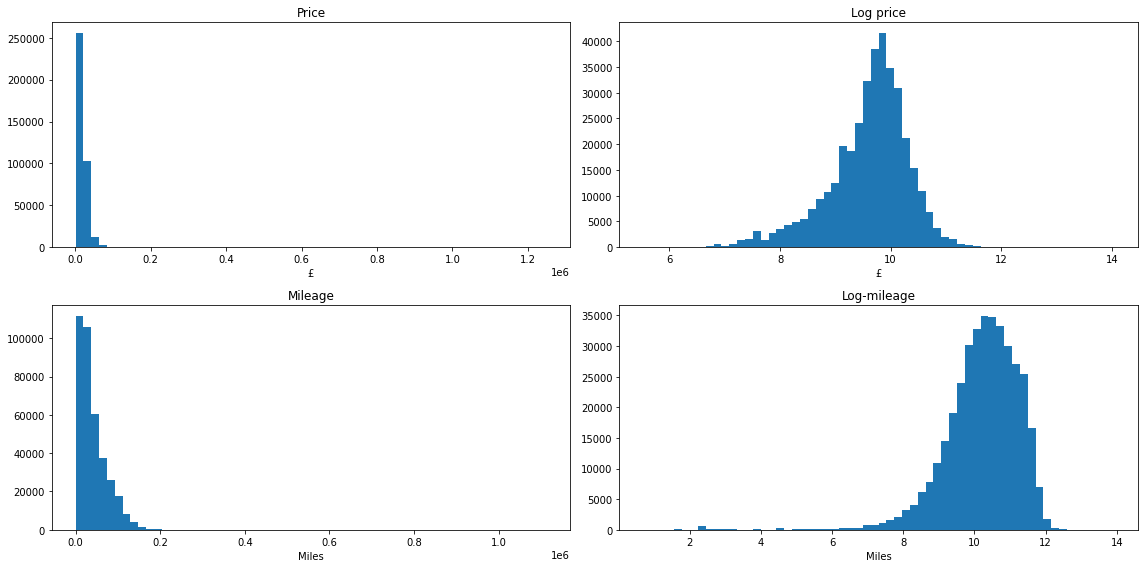

In [11]:
# Have a peek at the price and mileage distribution. 

# This is really just a quick look. No outliers have been dropped.
# You'll notice that I make a log-transofrm of the price and mileage data when obbserving the
# distributions - this will be discussed later.

ucars['log_price']=ucars.price.apply(lambda x: np.log(x))
ucars['log_mileage']=ucars.mileage.apply(lambda x: np.log(x))

# Logic to drop some outliers if wanted

#mask = np.abs((ucars.price - ucars.price.mean(0)) / ucars.price.std(0)) > 3
#ucars= ucars[~mask]
#ucars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');
#mask = np.abs((ucars.mileage - ucars.mileage.mean(0)) / ucars.mileage.std(0)) > 3
#ucars= ucars[~mask]
#ucars.mileage.plot(kind='hist', bins=50, title='Car Mileage');

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
ax[0,0].hist(ucars.price, bins=60)
ax[0,1].hist(ucars.log_price, bins=60)
ax[1,0].hist(ucars.mileage, bins=60)
ax[1,1].hist(ucars.log_mileage, bins=60)
ax[0,0].set_xlabel('£')
ax[0,1].set_xlabel('£')
ax[1,0].set_xlabel('Miles')
ax[1,1].set_xlabel('Miles')
ax[0,0].set_title('Price')
ax[0,1].set_title('Log price')
ax[1,0].set_title('Mileage')
ax[1,1].set_title('Log-mileage')
plt.tight_layout()
plt.show()

In [12]:
# Simplify the cars.name column. Probably not perfect.

# Save off the original name as on car listing
ucars['orig_name'] = ucars.name
ucars['lname']=ucars.name.apply(lambda x: x.lower())

# Lists of potential car bodies and names from Carsized.com, see associated notebook.
body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
       "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

# The aim is to standardise the car.name column a little in terms. I was just curious to see if this would work
# and it will come in useful for the further work when I try to merge carsized.com data with autotrader data.

results = []
# Iterate over all cars, extracting the lowercase name
for index, car in ucars.iterrows():
    lname = car[-1]
    # Set dummy variable to lowercase car name
    dummy = lname
    
    # Check if the lowercase name matches any in the name_list_from_carsized
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    
    # Iterate over bodies in body
    for bod in body:
        if bod in dummy:
            # Remove body information from the carname saved under dummy variable
            dummy = re.sub(' '+bod,'',dummy)
    
    # Append car name to results
    results.append(dummy)

# Overwrite name with this new carsized standardised name and drop the lname variable.
ucars['name']=results
ucars=ucars.drop('lname', axis=1)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 26)


In [13]:
# Add cars.used and cars.e_engine_kWh columns to be compatible with other datasets 

ucars['used']=1
ucars['e_engine_kWh']= np.nan

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 28)


In [14]:
# Removing some data enrty errors which have been identified by EDA later in the project.

#Remove SKODA 911 which stands as an aggressive outlier - data entry error
ucars[ucars.make=='SKODA'].sort_values(by='price',ascending=False).head(1)
dropindex = ucars[ucars.make=='SKODA'].sort_values(by='price',ascending=False).head(1).index.tolist()
ucars.drop(index=dropindex, inplace=True)

# Remove Mercedes missing a decimal which stands as an aggressive outlier - data entry error
ucars[ucars.make=='Mercedes-Benz'].sort_values(by='price',ascending=False).head(1)
dropindex = ucars[ucars.make=='Mercedes-Benz'].sort_values(by='price',ascending=False).head(1).index.tolist()
ucars.drop(index=dropindex, inplace=True)

# Remove two clear BHP errors which stand as an aggressive outlier - data entry error
ucars.BHP.sort_values(ascending=False).head(2)
dropindex = ucars.BHP.sort_values(ascending=False).head(2).index.tolist()
ucars.drop(index=dropindex, inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373912, 28)


In [15]:
# Output clean used cars data 
ucars=ucars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
ucars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_cars.csv'
ucars.to_csv(ucars_abspath, index=False, header=ucars.columns )

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373912, 28)


In [16]:
ucars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373912 entries, 0 to 594731
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           373912 non-null  object 
 1   name_subtitle  373912 non-null  object 
 2   year           373912 non-null  int64  
 3   price          373912 non-null  float64
 4   body           373912 non-null  object 
 5   mileage        373912 non-null  float64
 6   BHP            373912 non-null  float64
 7   doors          373912 non-null  object 
 8   transmission   373912 non-null  object 
 9   make           373912 non-null  object 
 10  fuel           373912 non-null  object 
 11  mpg            373912 non-null  object 
 12  drivertrain    373912 non-null  object 
 13  engine         373912 non-null  float64
 14  owners         191966 non-null  float64
 15  ULEZ           325815 non-null  object 
 16  dealer_area    318102 non-null  object 
 17  dealer_city    373640 non-nul

Note that not all of these variables are fully populated for all cars. This is not the list of variable to go into modelling, only the list of variables after cleaning.

In [17]:
ucars.describe()

,year,price,mileage,BHP,engine,owners,seller1,used,e_engine_kWh,log_price,log_mileage
count,373912.000000,3.739120e+05,3.739120e+05,373912.000000,373912.000000,191966.000000,307186.000000,373912.0,0.0,373912.000000,373912.000000
mean,2016.316286,1.839089e+04,4.037482e+04,155.388408,1.745712,1.865575,4.639705,1.0,NaN,9.602695,10.209382
std,3.514855,1.240517e+04,3.293635e+04,67.717272,0.557113,1.139197,0.441332,0.0,NaN,0.718112,1.077991
min,1994.000000,2.500000e+02,2.000000e+00,1.000000,0.600000,1.000000,1.000000,1.0,NaN,5.521461,0.693147
25%,2015.000000,1.049100e+04,1.600000e+04,113.000000,1.400000,1.000000,4.500000,1.0,NaN,9.258273,9.680344
50%,2017.000000,1.669000e+04,3.059200e+04,138.067061,1.600000,2.000000,4.700000,1.0,NaN,9.722565,10.328494
75%,2019.000000,2.349500e+04,5.660000e+04,187.376726,2.000000,2.000000,4.900000,1.0,NaN,10.064543,10.943764
max,2021.000000,1.250000e+06,1.113000e+06,972.386588,5.500000,26.000000,5.000000,1.0,NaN,14.038654,13.922570


In [19]:
ucars.sample(5)

,name,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,seller1,used,e_engine_kWh,log_price,log_mileage,orig_name,id,year_reg,link,href0
109181,audi q7,3.0 TDI V6 S line Tiptronic quattro (s/s) 5dr,2015,29950.0,SUV,86000.0,268.244576,5dr,Automatic,Audi,...,NaN,1,NaN,10.307285,11.362103,Audi Q7,202111099396340,NaN,https://www.autotrader.co.uk/car-details/20211...,NaN
108385,mercedes-benz slk,2.1 SLK250 CDI BlueEFFICIENCY AMG Sport 7G-Tro...,2015,15000.0,Convertible,29847.0,204.000000,2dr,Automatic,Mercedes-Benz,...,3.1,1,NaN,9.615805,10.303840,Mercedes-Benz SLK,202112070309652,2015 (15 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/stirlingshire/stirling/motorchoice-st...
19728,mini hatch,1.6 Cooper 3dr,2009,2995.0,Hatchback,84000.0,120.000000,3dr,Manual,MINI,...,4.7,1,NaN,8.004700,11.338572,MINI Hatch,202112180642140,2009 (59 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/warwickshire/birmingham/motor-island-...
300060,mini hatch,2.0 Cooper S Steptronic (s/s) 3dr,2018,19995.0,Hatchback,25921.0,189.349112,3dr,Automatic,MINI,...,4.8,1,NaN,9.903238,10.162809,MINI Hatch,202112020158764,2018 (68 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/dorset/gillingham/jason-mead-car-sale...
194420,kia sportage,CRDI 2 ISG 1.7 5dr,2017,12990.0,SUV,78702.0,114.398422,5dr,Manual,KIA,...,2.3,1,NaN,9.471935,11.273424,KIA Sportage,202112130464196,NaN,https://www.autotrader.co.uk/car-details/20211...,/dealers/northern-ireland/belfast/agnew-autoex...


## Used cars - electric

In [20]:
# Import all detailed files and make cars df, including year 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed_ev/'

li=[]
year_files = glob.glob(path + f"/*electric_used.csv")
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

uecars = pd.concat(li, axis=0, ignore_index=True)
uecars.drop_duplicates(subset=['link'], keep='first', inplace=True)
uecars.shape    

(4887, 20)

In [21]:
uecars.body.isnull().sum()

0

In [22]:
# Body is fine. No cleaning needed.
uecars.body.isnull().sum()

uecars.shape

(4887, 20)

In [23]:
# Clean BHP.

# Drop NaN BHP
uecars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
uecars.BHP = uecars.BHP.apply(lambda x: standardise_bhp(x))

uecars.shape

(4823, 20)

In [24]:
# Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
uecars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in uecars.href0]
uecars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in uecars.href0]

#If there are some seller ratings in seller0, move them to seller1
uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
uecars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in uecars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in uecars.iterrows():
    if pd.isnull(uecars.loc[index,'seller0']):
        uecars.loc[index,'seller0']=uecars.loc[index,'dealer_city_temp']
    #Tiny number of cars don't have a location, and they're all from one dealer in Oldbury.    
    if pd.isnull(uecars.loc[index,'seller0']):
        uecars.loc[index,'seller0']= 'Oldbury'
        
uecars['dealer_city'] = uecars['seller0']
uecars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

uecars.shape

(4823, 21)

In [25]:
# Populate uecars.e_engine_kWh from name_subtitle ~20% NaN. Not great but BHP supersedes it.

# For electric cars we can't measure engline volume in litres. This is a pain but not too problematic
# because fortunately BHP supersedes it. This won't be used in modelling. 
uecars['e_engine_kWh']=''
uecars['engine']=np.nan

for index, car in uecars.iterrows():
    car_subname = uecars.loc[index, 'name_subtitle']
    try:
        eenginesize = re.findall('[\d]+[.]?[\d]+[ ]?kwh',car_subname, flags=re.I)[0]
    except: 
        eenginesize = np.nan
    uecars.loc[index,'e_engine_kWh'] = eenginesize
    
uecars.e_engine_kWh= uecars.e_engine_kWh.apply(lambda x: float(str(x).lower().replace('kwh','')))
#uecars.dropna(subset=['engine'],inplace=True)

uecars.shape

(4823, 22)

In [26]:
# Make doors column. Drop 53 without info. 
     
uecars['doors'] = uecars.name_subtitle.apply(lambda x: extract_drs(x))

# Drop the remaining 53 uecars without door information    
uecars.drop(uecars[uecars.doors=='0dr'].index, inplace=True)

uecars.shape

(4770, 23)

In [27]:
# Clean uecars.price, make uecars.ID, clean uecars.year. Fix uecars.ULEZ 
to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

uecars.price=uecars.price.apply(lambda x: x.replace('£',''))
uecars.price=uecars.price.apply(lambda x: float(x.replace(',','')))
uecars['id'] =[x.split('/')[-1] for x in uecars.link]
uecars['year_reg']=uecars['year']
uecars['year']=uecars['YR']
uecars.drop('YR',inplace=True, axis=1)
uecars.owners=int(0)
uecars.ULEZ='ULEZ'


uecars.shape

(4770, 24)

In [28]:
# Set uecars.used = 1.

uecars['used']=1


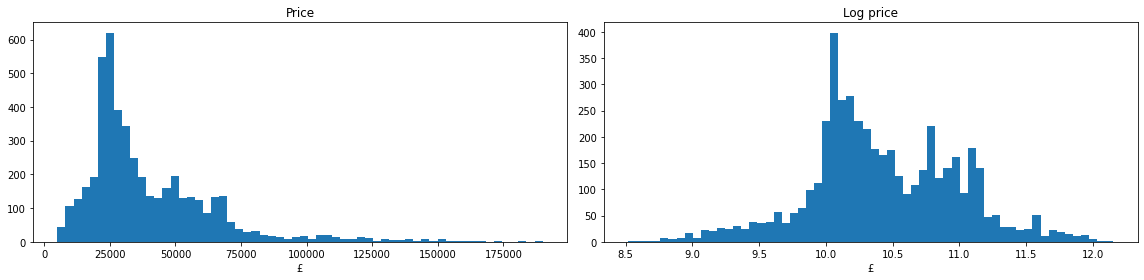

In [29]:
# Have a peek at the price and mileage distribution

uecars.drop(uecars[uecars.mileage.isnull()].index, inplace=True)
uecars['log_price']=uecars.price.apply(lambda x: np.log(x))
uecars['mileage']=uecars.mileage.apply(lambda x: float(x))
uecars['log_mileage']=uecars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(uecars.price, bins=60)
ax[1].hist(uecars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [30]:
# Simplify the name column a little. Probably not perfect 

uecars['orig_name'] = uecars.name
uecars['lname']=uecars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
        "SUV", "saloon","cabriolet","sedan"]

results = []
for index, car in uecars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)

uecars['name']=results
uecars=uecars.drop('lname', axis=1)

uecars.shape

(4740, 28)

In [31]:
# Output clean used cars data 
uecars=uecars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
uecars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_electric_cars.csv'
uecars.to_csv(uecars_abspath, index=False, header=uecars.columns )

In [32]:
uecars.mpg.value_counts()

Electric    4740
Name: mpg, dtype: int64

In [33]:
uecars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4740 entries, 0 to 4886
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4740 non-null   object 
 1   name_subtitle  4740 non-null   object 
 2   year           4740 non-null   int64  
 3   price          4740 non-null   float64
 4   body           4740 non-null   object 
 5   mileage        4740 non-null   float64
 6   BHP            4740 non-null   float64
 7   doors          4740 non-null   object 
 8   transmission   4740 non-null   object 
 9   make           4740 non-null   object 
 10  fuel           4740 non-null   object 
 11  mpg            4740 non-null   object 
 12  drivertrain    4740 non-null   object 
 13  engine         0 non-null      float64
 14  owners         4740 non-null   int64  
 15  ULEZ           4740 non-null   object 
 16  dealer_area    3880 non-null   object 
 17  dealer_city    4740 non-null   object 
 18  seller1 

## New cars - not electric

In [34]:
# Import all detailed files and make new ncars df, including year

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed/'

li=[]
year_files = glob.glob(path + f"/*2023_new.csv")
#print(len(year_files),'file(s) to load from', year)
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df['YR'] = '2022 new'
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

ncars = pd.concat(li, axis=0, ignore_index=True)
ncars.drop_duplicates(subset=['link'], keep='first', inplace=True)
ncars.shape  

(18906, 20)

In [35]:
#Clean ncars.body

#Create df of ncars will null body
nabody = ncars[ncars['body'].isnull()].copy()

#Encode body column but don't overwrite
to_encode = ['body']
ncars_e = ncars.copy()
for col in to_encode:
    le = LabelEncoder()
    ncars_e[col] = le.fit_transform(ncars_e[col]) 

#Iterate through null-body ncars and replace with corresponding modal body value based on name column grouping
for index, car in nabody.iterrows():
    carname=nabody.loc[index,'name']
    body=nabody.loc[index,'body']
    nabody.loc[index,'body'] = ncars_e[ncars_e['name']==carname].body.mode()[0]
    ncars_e.loc[index,'body'] = ncars_e[ncars_e['name']==carname].body.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ncars[col] = le.inverse_transform(ncars_e[col]) 

#After checking the remaining ncars without a body, it is clear that they are all vans!    
ncars.body = ['Van' if pd.Series(x).isnull()[0]==True else x for x in ncars.body]        

ncars.shape

(18906, 20)

In [36]:
#Clean ncars.BHP, taking values from ncars.engine where necessary. Drop remaining NaN.

# Unmerge some of the BHP entries which have engine size in there too.
for index, car in ncars[ncars['BHP'].str.contains('L', regex=True, na=False)].iterrows():
    ncars.loc[index, 'engine'] = str(ncars.loc[index, 'BHP']).split(' ')[0]
    ncars.loc[index, 'BHP'] = str(ncars.loc[index, 'BHP']).split(' ')[1].strip('()') 

# Drop NaN BHP
ncars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
ncars.BHP = ncars.BHP.apply(lambda x: standardise_bhp(x))

ncars.shape

(18890, 20)

In [37]:
#Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
ncars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in ncars.href0]
ncars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in ncars.href0]

#If there are some seller ratings in seller0, move them to seller1
ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
ncars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in ncars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in ncars.iterrows():
    if pd.isnull(ncars.loc[index,'seller0']):
        ncars.loc[index,'seller0']=ncars.loc[index,'dealer_city_temp']
        
ncars['dealer_city'] = ncars['seller0']
ncars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

ncars.shape

(18890, 21)

In [38]:
# Iterate over missing engine rows and use regex name_subtitle to extract engine size where possible. Convert to float

for index, car in ncars[ncars['engine'].isnull()].iterrows():
    car_subname = ncars.loc[index, 'name_subtitle']
    try:
        enginesize = re.findall('([0-9][.][0-9]+)',car_subname)[0]
    except: 
        enginesize = np.nan
    ncars.loc[index,'engine'] = float(enginesize)
    
ncars.engine= ncars.engine.apply(lambda x: float(str(x).replace('L','')))
ncars.dropna(subset=['engine'],inplace=True)

ncars.shape

(18890, 21)

In [39]:
# Make doors column

def extract_drs(x):
    drs = re.findall('( [1-8]d[Rr]?)',x, re.I)
    if len(drs) > 0:
        drs = str(drs[0]).lower()
    else:
        drs = re.findall('([1-8][ ]?door)',x, re.I)
        if len(drs) > 0:
            drs = str(drs[0])[0]+'dr'
        else:
            drs = re.findall('([1-8]dr)',x, re.I)
            if len(drs) > 0:
                drs = str(drs[0])[0]+'dr'
            else:
                drs = re.findall('(D-4D)',x, re.I)
                if len(drs) > 0:
                    drs = '4dr'
                else:
                    drs='0dr'
                
    if ('r' or 'R') not in drs:
        drs = drs.replace('d','dr')
    return drs.strip()
     
ncars['doors'] = ncars.name_subtitle.apply(lambda x: extract_drs(x))

#Create df of ncars with 0 doors
zerodoors = ncars[ncars['doors']=='0dr'].copy()

#Encode doors column but don't overwrite
to_encode = ['doors']
ncars_e = ncars.copy()
for col in to_encode:
    le = LabelEncoder()
    ncars_e[col] = le.fit_transform(ncars_e[col]) 

#Iterate through zero door ncars and replace with corresponding num doors based on name column grouping
for index, car in zerodoors.iterrows():
    carname=zerodoors.loc[index,'name']
    ncars_e.loc[index,'doors'] = ncars_e[ncars_e['name']==carname].doors.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ncars[col] = le.inverse_transform(ncars_e[col]) 

#Drop the remaining 226 ncars without door information    
ncars.dropna(subset=['doors'],inplace=True)
    
ncars.shape

(18890, 22)

In [40]:
# Clean ncars.mileage

#Drop them - only 283
ncars.mileage = '0'

ncars.shape

(18890, 22)

In [41]:
# Clean ncars.fuel

#Drop them - only 12
ncars.dropna(subset=['fuel'],inplace=True)

ncars.shape

(18890, 22)

In [42]:
# Clean ncars.price, make ncars.ID, clean ncars.year 

to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

ncars.price=ncars.price.apply(lambda x: x.replace('£',''))
ncars.price=ncars.price.apply(lambda x: float(x.replace(',','')))
ncars['id'] =[x.split('/')[-1] for x in ncars.link]
ncars['year_reg']=ncars.year
ncars['year']= 2022
ncars.drop('YR',inplace=True, axis=1)

ncars.shape

(18890, 23)

In [43]:
#Obtain ncars.ll_search <-- Doesn't actually work with nominatim openstreetmap. Probably not needed.

# ncars['ll_search']=''
# ll_search_series = []
# for index, car in tqdm(ncars.iterrows()):
#     dc = str(car[19])
#     da = str(car[18])
#     if dc == 'nan':
#         dc = ''
#     if da == 'nan':
#         da = ''
#     car[23] = dc+' '+da
#     ll_search_series.append(car[23])
# ncars['ll_search'] = ll_search_series


In [44]:
#Iterate over ncars to convert dealer_city to lat/lon. 2s per car makes this a 2+day cell. Running in other workbook. 

# lat_series = []
# lon_series = []

# for index, car in tqdm(ncars.iterrows()):
#     address = car[19] + ' UK'
#     url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
#     response = requests.get(url).json()
#     lat_series.append(response[0]["lat"])
#     lon_series.append(response[0]["lon"])
    
# ncars['seller_lat']=lat_series
# ncars['seller_lon']=lon_series
    

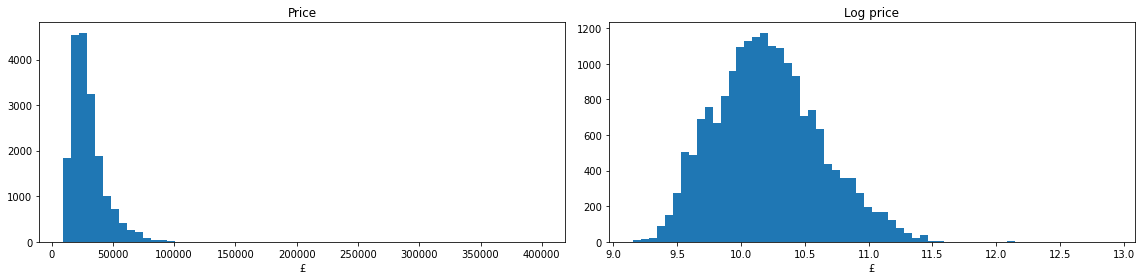

In [45]:
# Have a peek at the price and mileage distribution

ncars['log_price']=ncars.price.apply(lambda x: np.log(x))
ncars['mileage']=ncars.mileage.apply(lambda x: float(x))
ncars['log_mileage']=ncars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(ncars.price, bins=60)
ax[1].hist(ncars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [46]:
# Simplify the name column a little. Probably not perfect 

ncars['orig_name'] = ncars.name
ncars['lname']=ncars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
       "SUV", "saloon","cabriolet","sedan"]

results = []
for index, car in ncars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)
results

ncars['name']=results
ncars=ncars.drop('lname', axis=1)

ncars.shape

(18890, 26)

In [47]:
# Add ncars.used and ncars.e_engine_kWh columns to be compatible with other datasets 

ncars['used']=0
ncars['e_engine_kWh']= np.nan

ncars.shape

(18890, 28)

In [48]:
# Output clean used cars data 
ncars=ncars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
ncars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_cars.csv'
ncars.to_csv(ncars_abspath, index=False, header=ncars.columns )

In [49]:
ncars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18890 entries, 0 to 50386
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           18890 non-null  object 
 1   name_subtitle  18890 non-null  object 
 2   year           18890 non-null  int64  
 3   price          18890 non-null  float64
 4   body           18890 non-null  object 
 5   mileage        18890 non-null  float64
 6   BHP            18890 non-null  float64
 7   doors          18890 non-null  object 
 8   transmission   18890 non-null  object 
 9   make           18890 non-null  object 
 10  fuel           18890 non-null  object 
 11  mpg            18890 non-null  object 
 12  drivertrain    18890 non-null  object 
 13  engine         18890 non-null  float64
 14  owners         0 non-null      float64
 15  ULEZ           18780 non-null  object 
 16  dealer_area    16203 non-null  object 
 17  dealer_city    18686 non-null  object 
 18  seller

## New cars - electric

In [50]:
# Import all detailed files and make new ncars df, including year

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed_ev/'

li=[]
year_files = glob.glob(path + f"/*2023_electric_new.csv")
#print(len(year_files),'file(s) to load from', year)
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df['YR'] = '2022 new'
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

necars = pd.concat(li, axis=0, ignore_index=True)
necars.drop_duplicates(subset=['link'], keep='first', inplace=True)
necars.shape  

(2816, 20)

In [51]:
# Body is fine. No cleaning needed.

necars.shape

(2816, 20)

In [52]:
# Clean BHP.

# Drop NaN BHP
necars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
necars.BHP = necars.BHP.apply(lambda x: standardise_bhp(x))

necars.shape

(2768, 20)

In [53]:
#Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
necars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in necars.href0]
necars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in necars.href0]

#If there are some seller ratings in seller0, move them to seller1
necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
necars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in necars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in necars.iterrows():
    if pd.isnull(necars.loc[index,'seller0']):
        necars.loc[index,'seller0']=necars.loc[index,'dealer_city_temp']
    #Tiny number of cars don't have a location, and they're all from one dealer in Oldbury.    
    if pd.isnull(necars.loc[index,'seller0']):
        necars.loc[index,'seller0']= 'Oldbury'
        
necars['dealer_city'] = necars['seller0']
necars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

necars.shape

(2768, 21)

In [54]:
# Populate necars.e_engine_kWh from name_subtitle ~20% NaN. Not great but BHP supersedes it.

necars['e_engine_kWh']=''
necars['engine']=np.nan

for index, car in necars.iterrows():
    car_subname = necars.loc[index, 'name_subtitle']
    try:
        eenginesize = re.findall('[\d]+[.]?[\d]+[ ]?kwh',car_subname, flags=re.I)[0]
    except: 
        eenginesize = np.nan
    necars.loc[index,'e_engine_kWh'] = eenginesize
    
necars.e_engine_kWh= necars.e_engine_kWh.apply(lambda x: float(str(x).lower().replace('kwh','')))
#necars.dropna(subset=['engine'],inplace=True)

necars.shape

(2768, 22)

In [55]:
# Make doors column. Drop 4 without info. 
     
necars['doors'] = necars.name_subtitle.apply(lambda x: extract_drs(x))

# Drop the remaining 4 necars without door information    
necars.drop(necars[necars.doors=='0dr'].index, inplace=True)

necars.shape

(2764, 23)

In [56]:
# Clean necars.price, make necars.ID, clean necars.year 
to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

necars.price=necars.price.apply(lambda x: x.replace('£',''))
necars.price=necars.price.apply(lambda x: float(x.replace(',','')))
necars['id'] =[x.split('/')[-1] for x in necars.link]
necars['year_reg']=necars.YR
necars['year']=2022
necars.drop('YR',inplace=True, axis=1)
necars.owners=int(0)
necars.ULEZ='ULEZ'


necars.shape

(2764, 24)

In [57]:
# Set necars.mileage = 0. Set necars.used = 0.

necars['mileage']= 0
necars['used']=0


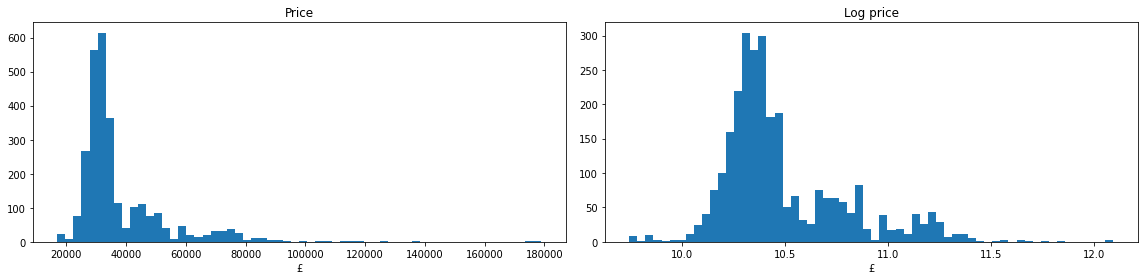

In [58]:
# Have a peek at the price and mileage distribution

necars['log_price']=necars.price.apply(lambda x: np.log(x))
necars['mileage']=necars.mileage.apply(lambda x: float(x))
necars['log_mileage']=necars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(necars.price, bins=60)
ax[1].hist(necars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [59]:
# Simplify the name column a little. Probably some room for improvement here but it will be used when merging 

necars['orig_name'] = necars.name
necars['lname']=necars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
        "SUV", "saloon","cabriolet","sedan"]

results = []
for index, car in necars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)

necars['name']=results
necars=necars.drop('lname', axis=1)

necars.shape

(2764, 28)

In [60]:
# Output clean used cars data 

# Sort the order of the columns.
necars=necars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
necars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_electric_cars.csv'
necars.to_csv(necars_abspath, index=False, header=necars.columns )

In [61]:
necars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2764 entries, 0 to 2815
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2764 non-null   object 
 1   name_subtitle  2764 non-null   object 
 2   year           2764 non-null   int64  
 3   price          2764 non-null   float64
 4   body           2764 non-null   object 
 5   mileage        2764 non-null   float64
 6   BHP            2764 non-null   float64
 7   doors          2764 non-null   object 
 8   transmission   2764 non-null   object 
 9   make           2764 non-null   object 
 10  fuel           2764 non-null   object 
 11  mpg            2764 non-null   object 
 12  drivertrain    2764 non-null   object 
 13  engine         0 non-null      float64
 14  owners         2764 non-null   int64  
 15  ULEZ           2764 non-null   object 
 16  dealer_area    2415 non-null   object 
 17  dealer_city    2764 non-null   object 
 18  seller1 

# Combine dataframes

OK, so we have cleaned the data in four batches, now I want to combine it into a single DataFrame.

The four batches so far have already been engineered to have the same series of variables in the same order, so I can concatenate them.

## Combine input data

One large file is easier to work with than four small ones, so now it's time to concatenate them all.

In [62]:
# Read and cat clean cars data 

# Each of my absolute paths for  the datasets cleaned so far. If you're trying to recreate this project
# yourself then this will need to be tailored.
car_dataframes = [ucars_abspath, ncars_abspath, necars_abspath, uecars_abspath]
li=[]
for filename in car_dataframes:
    df = pd.read_csv(filename, index_col=None, header=0 )
    # Drop duplicates
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

# Concatenate the four dataframes into one.     
cars = pd.concat(li, axis=0, ignore_index=True)
cars.drop_duplicates(subset=['id'], keep='first', inplace=True)
print('DataFrame shape:',cars.shape)

DataFrame shape: (400245, 28)


In [63]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400245 entries, 0 to 400305
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           400245 non-null  object 
 1   name_subtitle  400245 non-null  object 
 2   year           400245 non-null  int64  
 3   price          400245 non-null  float64
 4   body           400245 non-null  object 
 5   mileage        400245 non-null  float64
 6   BHP            400245 non-null  float64
 7   doors          400245 non-null  object 
 8   transmission   400245 non-null  object 
 9   make           400245 non-null  object 
 10  fuel           400245 non-null  object 
 11  mpg            400245 non-null  object 
 12  drivertrain    400245 non-null  object 
 13  engine         392741 non-null  float64
 14  owners         199447 non-null  float64
 15  ULEZ           352088 non-null  object 
 16  dealer_area    340545 non-null  object 
 17  dealer_city    399769 non-nul

In [64]:
cars.describe()

,year,price,mileage,BHP,engine,owners,seller1,used,e_engine_kWh,log_price,log_mileage,id
count,400245.000000,4.002450e+05,4.002450e+05,400245.000000,392741.000000,199447.000000,329526.000000,400245.000000,5343.000000,400245.000000,4.002450e+05,4.002450e+05
mean,2016.663406,1.930479e+04,3.787096e+04,156.053268,1.734427,1.795444,4.636698,0.945908,55.656410,9.647099,-inf,2.021445e+14
std,3.652162,1.319212e+04,3.327608e+04,69.251285,0.556279,1.172630,0.442237,0.226199,19.113811,0.723010,NaN,4.517598e+10
min,1994.000000,2.500000e+02,0.000000e+00,1.000000,0.600000,0.000000,1.000000,0.000000,11.000000,5.521461,-inf,2.015062e+14
25%,2015.000000,1.099100e+04,1.347300e+04,113.000000,1.400000,1.000000,4.500000,1.000000,42.000000,9.304832,9.508443e+00,2.021110e+14
50%,2018.000000,1.724900e+04,2.833300e+04,138.067061,1.600000,1.000000,4.700000,1.000000,50.000000,9.755509,1.025178e+01,2.021121e+14
75%,2019.000000,2.450000e+04,5.400000e+04,187.376726,2.000000,2.000000,4.900000,1.000000,71.000000,10.106428,1.089674e+01,2.022011e+14
max,2022.000000,1.250000e+06,1.113000e+06,972.386588,5.500000,26.000000,5.000000,1.000000,125.000000,14.038654,1.392257e+01,2.022021e+14


In [65]:
cars.sample(5)

,name,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,seller1,used,e_engine_kWh,log_price,log_mileage,orig_name,id,year_reg,link,href0
160338,ford fiesta,Titanium Hatchback 5dr Petrol Manual 97 g/km 9...,2017,12991.0,Hatchback,27480.0,98.619329,5dr,Manual,Ford,...,4.7,1,NaN,9.472012,10.221214,Ford Fiesta,202201201567638,2017 (67 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/berkshire/wokingham/think-ford-woking...
392314,volkswagen t-cross,T-Cross SE 1.0 TSI 110PS 6-spe 5dr,2022,23095.0,SUV,0.0,108.481262,5dr,Manual,Volkswagen,...,3.0,0,NaN,10.047371,-inf,Volkswagen T-Cross,202201281867246,NaN,https://www.autotrader.co.uk/classified/advert...,/dealers/west-yorkshire/bradford/jct600-volksw...
105124,peugeot 308,1.6 THP GT (s/s) 5dr,2015,11990.0,Hatchback,38210.0,205.000000,5dr,Manual,Peugeot,...,5.0,1,NaN,9.391828,10.550853,Peugeot 308,202201091161974,2015 (65 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/buckinghamshire/high-wycombe/autohave...
236602,mercedes-benz cla class,CLA 220d AMG Line Night Edition 2.1 4dr,2018,22990.0,Saloon,57404.0,167.652860,4dr,Automatic,Mercedes-Benz,...,4.7,1,NaN,10.042815,10.957869,Mercedes-Benz Cla Class,202201191510217,2018 (68 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/norwich/heigham-street/mercedes-benz-...
320180,hyundai kona,1.6T GDi Blue Drive Premium GT 4WD DCT 5dr,2019,20998.0,SUV,19500.0,174.556213,5dr,Automatic,Hyundai,...,NaN,1,NaN,9.952182,9.878170,Hyundai Kona,202201211593395,2019 (19 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/north-humberside/hessle/carsupermarke...


In [66]:
# Output all cars data - still containsa a few NaNs
cars=cars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
cars.to_csv(cars_abspath, index=False, header=cars.columns )

This file (above) is the input data to the [EDA](#EDA-on-used-cars) in section in 4 of this Notebook, ans also is the input data to the modelling in Notebook 5 of 6.

## Join county, latitude and longitude

Merging latitude and longitude information first, then county information second to the dataframe. The lat/lon merge is a one-one merge based on car ID. The county merge is then a many-to-one merge based on rounded lat/lon figures.

All GeoCoding is performed in Notebook 03_GeoCoding, where .csv files are created/condition for merging. 

Note that this location information was not included in the first version of the model. It was part of the further work which I undertook when experimenting with ways to improve model performance after the first version. 

In [67]:
# Import all latlon files and make ll dataframe 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/latlon/'

li=[]
files = glob.glob(path + f"/*.csv")
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    li.append(df)

ll = pd.concat(li, axis=0, ignore_index=True)
ll.drop_duplicates(subset=['id'], keep='first', inplace=True)
ll = ll[['id','dealer_lat','dealer_lon']]
ll.shape    

(398983, 3)

In [68]:
# Merge cars and lat/lon df on 'id'. One-to-one merge.

cars = pd.merge(
    cars,
    ll,
    how="left",
    on='id',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate="one_to_one"
)

cars.shape

(400245, 30)

In [69]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400245 entries, 0 to 400244
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           400245 non-null  object 
 1   name_subtitle  400245 non-null  object 
 2   year           400245 non-null  int64  
 3   price          400245 non-null  float64
 4   body           400245 non-null  object 
 5   mileage        400245 non-null  float64
 6   BHP            400245 non-null  float64
 7   doors          400245 non-null  object 
 8   transmission   400245 non-null  object 
 9   make           400245 non-null  object 
 10  fuel           400245 non-null  object 
 11  mpg            400245 non-null  object 
 12  drivertrain    400245 non-null  object 
 13  engine         392741 non-null  float64
 14  owners         199447 non-null  float64
 15  ULEZ           352088 non-null  object 
 16  dealer_area    340545 non-null  object 
 17  dealer_city    399769 non-nul

In [70]:
# Read counties csv file prepared in 03_GeoCoding

counties = pd.read_csv('/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/04_merge_counties.csv')
# Observe counties columns
counties.columns

Index(['original_ll', 'geocode', 'county', 'postcode', 'postcode_short',
       'dealer_lat', 'dealer_lon', 'dealer_lat_rnd', 'dealer_lon_rnd'],
      dtype='object')

In [71]:
# Observe cars columns
cars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'dealer_area', 'dealer_city', 'seller1', 'used',
       'e_engine_kWh', 'log_price', 'log_mileage', 'orig_name', 'id',
       'year_reg', 'link', 'href0', 'dealer_lat', 'dealer_lon'],
      dtype='object')

In [72]:
# Generate rounded lat/lon in cars dataframe to match counties. This rounding is approx accurate to 1 m
cars['dealer_lat_rnd']=cars.dealer_lat.apply(lambda x: round(x,5))
cars['dealer_lon_rnd']=cars.dealer_lon.apply(lambda x: round(x,5))

In [73]:
# Left merge counties data into cars dataframe based on rounded lat/lon. Many-to-one merge. 
cars = pd.merge(
    cars,
    counties,
    how="left",
    left_on=['dealer_lat_rnd','dealer_lon_rnd'],
    right_on=['dealer_lat_rnd','dealer_lon_rnd'],
    sort=False,
    suffixes=("", "_y"),
    copy=True,
    indicator=False,
)

In [74]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400245 entries, 0 to 400244
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            400245 non-null  object 
 1   name_subtitle   400245 non-null  object 
 2   year            400245 non-null  int64  
 3   price           400245 non-null  float64
 4   body            400245 non-null  object 
 5   mileage         400245 non-null  float64
 6   BHP             400245 non-null  float64
 7   doors           400245 non-null  object 
 8   transmission    400245 non-null  object 
 9   make            400245 non-null  object 
 10  fuel            400245 non-null  object 
 11  mpg             400245 non-null  object 
 12  drivertrain     400245 non-null  object 
 13  engine          392741 non-null  float64
 14  owners          199447 non-null  float64
 15  ULEZ            352088 non-null  object 
 16  dealer_area     340545 non-null  object 
 17  dealer_cit

Note that only 398695/400245 cars have lat/lon/county data. Pretty good. 

In [75]:
# Drop extra columns no longer needed
cars.drop(labels=['dealer_lat_rnd', 'dealer_lon_rnd', 'original_ll',
       'dealer_lat_y', 'dealer_lon_y'], axis=1, inplace=True)

In [76]:
# Quick look at car counts in each county. It looks as expected - Most in London, least in Shetland and Orkney!
cars.county.value_counts()

Greater London             32808
West Midlands              32761
West Yorkshire             18519
Greater Manchester         17016
Surrey                     12955
                           ...  
Argyll and Bute Council       33
Isle of Wight                 26
Na h-Eileanan an Iar           3
Orkney Islands                 1
Shetland Islands               1
Name: county, Length: 136, dtype: int64

In [77]:
# Output all cars data with lat&lon and county - still containsa a few NaNs
cars=cars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','county','dealer_area','dealer_city'
            ,'dealer_lat','dealer_lon','geocode'
            ,'county', 'postcode', 'postcode_short','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars_ll.csv'
cars.to_csv(cars_abspath, index=False, header=cars.columns )

In [78]:
# A final look at the cars data frame info before I move onto merging the car size data from 
# Notebook 02_Carsized_scrape
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400245 entries, 0 to 400244
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            400245 non-null  object 
 1   name_subtitle   400245 non-null  object 
 2   year            400245 non-null  int64  
 3   price           400245 non-null  float64
 4   body            400245 non-null  object 
 5   mileage         400245 non-null  float64
 6   BHP             400245 non-null  float64
 7   doors           400245 non-null  object 
 8   transmission    400245 non-null  object 
 9   make            400245 non-null  object 
 10  fuel            400245 non-null  object 
 11  mpg             400245 non-null  object 
 12  drivertrain     400245 non-null  object 
 13  engine          392741 non-null  float64
 14  owners          199447 non-null  float64
 15  ULEZ            352088 non-null  object 
 16  county          398695 non-null  object 
 17  dealer_are

## Merging the car size details

Now I merge in the car dimension information from Notebook 02_Carsized_scrape.

Note that this cars size data isn't actually used in the primary modelling, it was considered further work which was used to improve the model after the first version had been finished. 

In [79]:
# Read all car data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars_ll.csv'
dfcars = pd.read_csv(abspath)

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_carsized_dims_for_merge.csv'
dfsize = pd.read_csv(abspath)

# A small number of string manipulations to improve merging of two dataframes using name column as one of the labels.
# Note that most of these are simple american/english naming conventions. This doesn't capture them all - there are
# still a number of failed matches between the dataframes as you'll see later, but it's OK for now. If I had more
# time I would go through it in more detail.

# Iterate over rows in the dfcars dataframe and replace some string elements, creating a match_name columns at the 
# end
match_name=[]
for index, car in dfcars.iterrows():
    name = car[0]
    name = name.replace('series','')
    name = name.replace('-',' ')
    name = name.replace('class','')
    name = name.replace('hatch','cooper')
    name = name.replace('mini','mini cooper')
    name = name.replace('cooper cooper','cooper')
    name = name.replace('cooper clubman','clubman')
    name = name.replace('cooper countryman','countryman')
    name = name.replace('jazz','jazz fit')
    name = name.strip()
    name = name.replace('mercedes benz','mercedes-benz')
    match_name.append(name)
dfcars['match_name']=match_name

In [80]:
# Observe columns
dfcars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county.1', 'postcode', 'postcode_short',
       'seller1', 'used', 'e_engine_kWh', 'log_price', 'log_mileage',
       'orig_name', 'id', 'year_reg', 'link', 'href0', 'match_name'],
      dtype='object')

In [81]:
# Merge dfcars with dfsize on match_name, body and year. Many-to-one merge.

cars_size = pd.merge(
    dfcars,
    dfsize,
    how="left",
    left_on=['match_name','body','year'],
    right_on=['name','body','year'],
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
)

# Drop duplicates as a precaution. Likely not needed.
cars_size.drop_duplicates(subset='id', keep='first',inplace=True)
print('All data size',cars_size.shape)

# Evaluate the number of failed matches. 
failed_match = cars_size[cars_size.cargo_volume_L.isnull()].copy()
failed_match.drop_duplicates(subset='id', keep='first',inplace=True)
print('Null cargo data size',failed_match.shape)

All data size (400245, 44)
Null cargo data size (48402, 44)


Around 12.5% of cars do not have corresponding dimensions. This isn't great but it isn't criminal either.

Below I have a look at which sort of cars are not matched, but I don't have the time to fix them here. It's just for awareness.

In [82]:
# Failed match value counts
failed_match['name_x'].value_counts(dropna=False).head(10)

bmw 2 series         1876
vauxhall insignia    1419
vauxhall zafira      1324
skoda octavia        1192
ford mondeo           992
ford c-max            871
abarth 595            789
citroen c4 cactus     757
ford s-max            733
audi s3               702
Name: name_x, dtype: int64

In [83]:
# There are a few failed matches, but at this stage I have to let it go. If I was being paid I could fix these.
failed_match[failed_match.cargo_volume_L.isnull()].match_name.value_counts(dropna=False).head(50)
failed_match[failed_match.match_name=='bmw 2'].sample(5)

,name_x,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,href0,match_name,name_y,wheelbase_cm,length_cm,width_cm,height_cm,ground_clearance_cm,cargo_volume_L,max_cargo_volume_L
191866,bmw 2 series,220d M Sport 5dr [Nav] Step Auto 2.0,2018,21745.0,MPV,24908.0,190.000000,5dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306385,bmw 2 series,220d xDrive M Sport Active Tourer 2.0 5dr,2019,26850.0,MPV,20386.0,190.000000,5dr,Automatic,BMW,...,/dealers/oxfordshire/oxford/north-oxford-bmw-2...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202767,bmw 2 series,2.0 220D xDrive SE Active Tourer 5dr,2018,23000.0,MPV,12060.0,190.000000,5dr,Automatic,BMW,...,/dealers/greater-london/london/cargiant-13713?...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204536,bmw 2 series,1.5 218i Sport Gran Tourer Auto (s/s) 5dr,2018,19999.0,MPV,30000.0,134.122288,5dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202779,bmw 2 series,220d Xdrive Luxury Gran Tourer 2 2.0 5dr,2018,21499.0,MPV,35630.0,190.000000,5dr,Automatic,BMW,...,/dealers/northumberland/newcastle-upon-tyne/di...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# cars_size shape before dropping nans
cars_size.shape

(400245, 44)

In [85]:
# cars_size shape after dropping nans

cars_size.dropna(subset = ['cargo_volume_L'], inplace=True)
cars_size.dropna(subset = ['dealer_lat'], inplace=True)
cars_size.dropna(subset = ['dealer_lon'], inplace=True)
cars_size.dropna(subset = ['county'], inplace=True)

cars_size = cars_size[cars_size.cargo_volume_L!=0.0].copy()
cars_size.shape

(335824, 44)

In [86]:
cars_size.columns

Index(['name_x', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county.1', 'postcode', 'postcode_short',
       'seller1', 'used', 'e_engine_kWh', 'log_price', 'log_mileage',
       'orig_name', 'id', 'year_reg', 'link', 'href0', 'match_name', 'name_y',
       'wheelbase_cm', 'length_cm', 'width_cm', 'height_cm',
       'ground_clearance_cm', 'cargo_volume_L', 'max_cargo_volume_L'],
      dtype='object')

In [87]:
# Output all cars data with lat&lon and boot size stats - still containsa a few NaNs but 335824 is
# a good number of car listings to use for modelling in further work! 

cars_size.columns = ['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county', 'postcode', 'postcode_short',
       'seller1', 'used', 'e_engine_kWh', 'log_price', 'log_mileage',
       'orig_name', 'id', 'year_reg', 'link', 'href0', 'match_name', 'name_y',
       'wheelbase_cm', 'length_cm', 'width_cm', 'height_cm',
       'ground_clearance_cm', 'cargo_volume_L', 'max_cargo_volume_L']

cars_size=cars_size[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','geocode', 'county', 'postcode', 'postcode_short'
            ,'dealer_lat','dealer_lon','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0'
            ,'wheelbase_cm', 'length_cm', 'width_cm'
            ,'height_cm', 'ground_clearance_cm', 'cargo_volume_L']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'
cars_size.to_csv(cars_abspath, index=False, header=cars_size.columns )

In [88]:
# One final look at the dataframe info which will be used for the 2nd version of modelling
cars_size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335824 entries, 171 to 400243
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 335824 non-null  object 
 1   name_subtitle        335824 non-null  object 
 2   year                 335824 non-null  int64  
 3   price                335824 non-null  float64
 4   body                 335824 non-null  object 
 5   mileage              335824 non-null  float64
 6   BHP                  335824 non-null  float64
 7   doors                335824 non-null  object 
 8   transmission         335824 non-null  object 
 9   make                 335824 non-null  object 
 10  fuel                 335824 non-null  object 
 11  mpg                  335824 non-null  object 
 12  drivertrain          335824 non-null  object 
 13  engine               330407 non-null  float64
 14  owners               165740 non-null  float64
 15  ULEZ           

# EDA on used cars

This section contains a general exploration of the **used car** data, before the lat/lon, county and boot size information were added. This is the data which have been used for modelling in the first version of the model. 

## Pretty general interest plots

The aim of this section is to provide a general overview of the used car data which has been scraped. I'll look at some distributions of the continuous variables and try to evaluate how some of the categorical variables might be impacting used car price.

In [89]:
# Read clean used cars data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('All cars',df.shape)
# Drop new cars - not part of my model
df = df[df['used']==1]
print('Used cars',df.shape)

All cars (400245, 28)
Used cars (378595, 28)


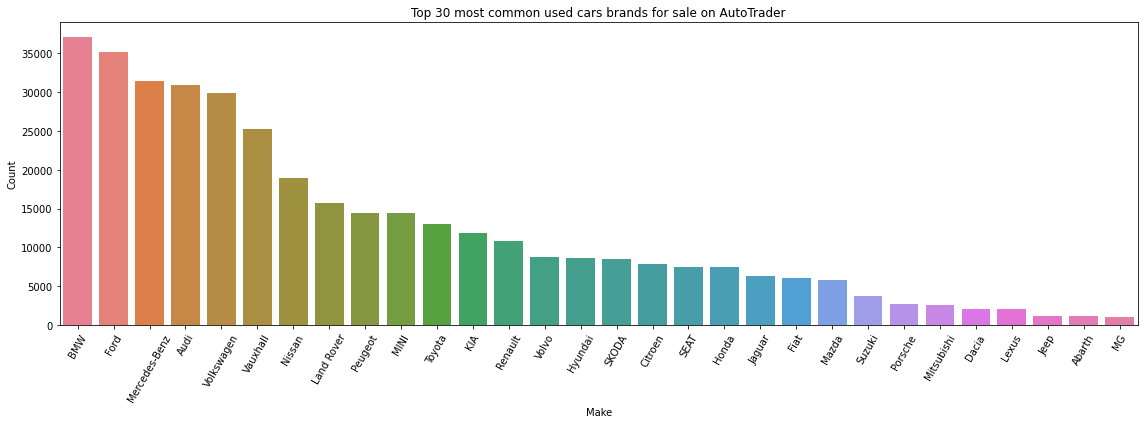

In [90]:
# Plot of make frequency. Note that car brand==car make. With hindsight I wish I used the term brand but it's too
# late to change it now.

# Groupby car make sort the counted values. 
df.groupby(by='make')['name'].count().sort_values(ascending=False).head(30).reset_index()

# Plot with seaborn
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.barplot(x="make", y="name", data=df.groupby(by='make')['name'].count().sort_values(ascending=False).head(30).reset_index()
            ,palette='husl').set_title('Top 30 most common used cars brands for sale on AutoTrader')
ax.set_xlabel('Make')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=60)
plt.tight_layout()
# Save to pdf
plt.savefig('carbrandcount.pdf',bbox_inches='tight')
plt.show()


A BMW is the most common used car for sale in the UK at the start of February 2022, with over 35,000 used BMWs on the market. This makes up just under 10% of all used cars on AutoTrader. German brands in general are rather popular with 4/5 of the most common brands being German! 

94% of used cars can be described by the top 23 brands. At this stage I do not drop data from the car brands which are poorly represented, but later just before the modelling (in Notebook 05_modelling) I drop brands with less than 200 used cars recorded.

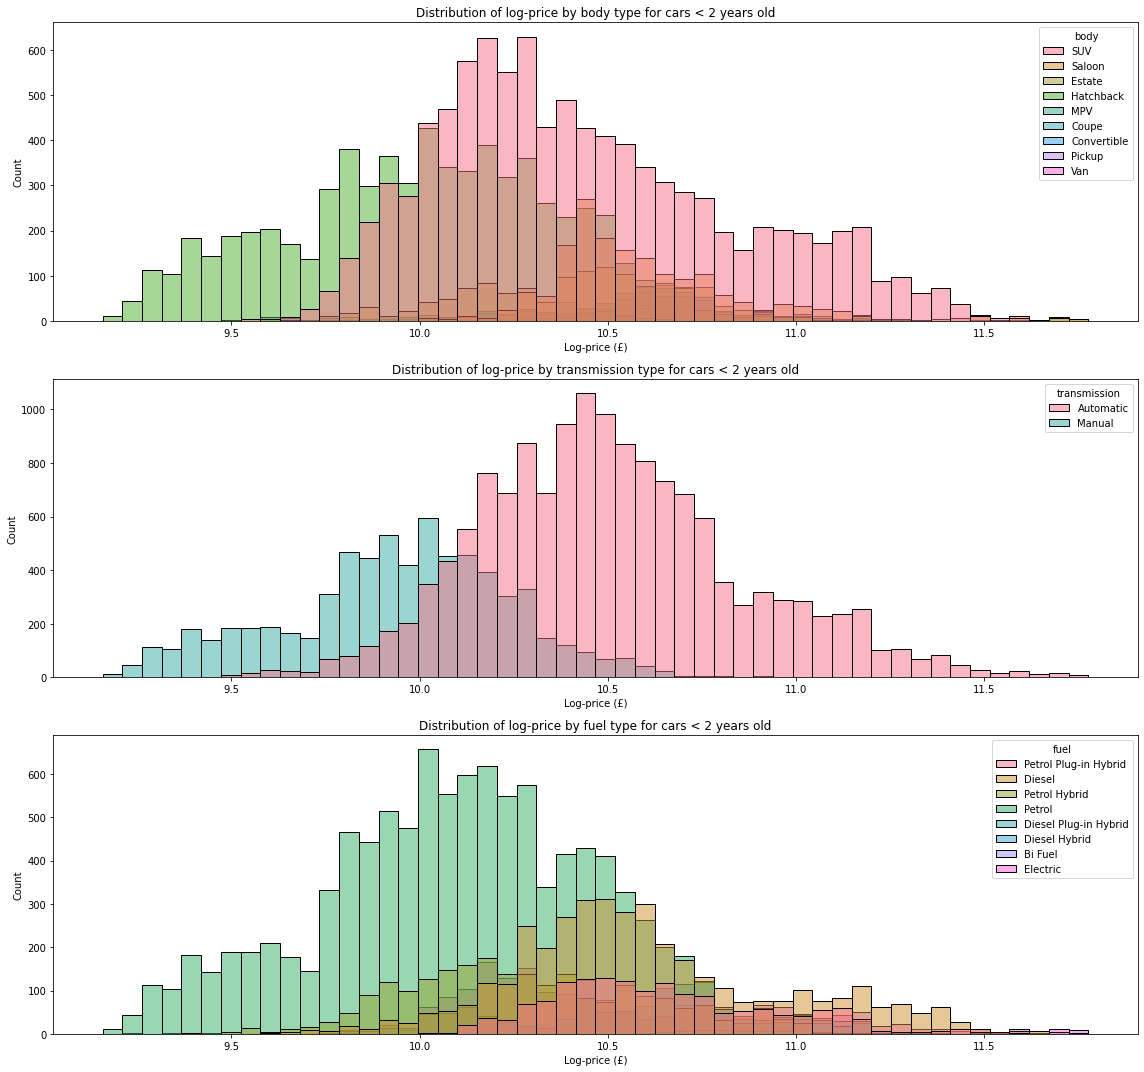

In [91]:
# Plot of pridce distributions by categorical variables using Seaborn - remove outliers first in log space 
# X-axis is presented in log form because it can show better distribution differentiation. 

dfo=df.copy()
mask = np.abs((dfo.log_price - dfo.log_price.mean(0)) / dfo.log_price.std(0)) > 3
dfo= dfo[~mask]


fig, ax = plt.subplots(nrows=3, figsize=(16,15))
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="body",palette='husl',bins=50, legend=True, ax=ax[0]).set_title('Distribution of log-price by body type for cars < 2 years old')
ax[0].set_xlabel('Log-price (£)')
ax[0].set_ylabel('Count')
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="transmission",palette='husl',bins=50, legend=True, ax=ax[1]).set_title('Distribution of log-price by transmission type for cars < 2 years old')
ax[1].set_xlabel('Log-price (£)')
ax[1].set_ylabel('Count')
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="fuel",palette='husl',bins=50, legend=True, ax=ax[2]).set_title('Distribution of log-price by fuel type for cars < 2 years old')
ax[2].set_xlabel('Log-price (£)')
ax[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

It is clear that some of these categorical variables will be useful in predicting the price of a used car - manual gearboxes are clearly cheaper than automatic ones.

It's a little harder to draw conclusions from the other two plots. It can be seen that hatchback cars are generally cheaper, with SUV cars more expensive than hatchbacks, but other body types are generally less represented and generally overlay on the distribution plot. In terms of fuel type, it looks like petrol cars are the cheapest, with electric cars being more expensive, less represented. 

None of these insights are surprising. I'm happy with the start of this data analysis.

In these three categorical variables presented it looks like transmission variable provides the best information on car price. Automatic cars are clearly more expensive than manual cars.

In the plots below I try to capture the average mileage, average price and count of cars when divided by different categorical variables. It has mostly worked well, although I haven't been able to make the size of the dots in the key look neat. The general idea is still conveyed by the plot so I have retained these. Interpretation will be below.

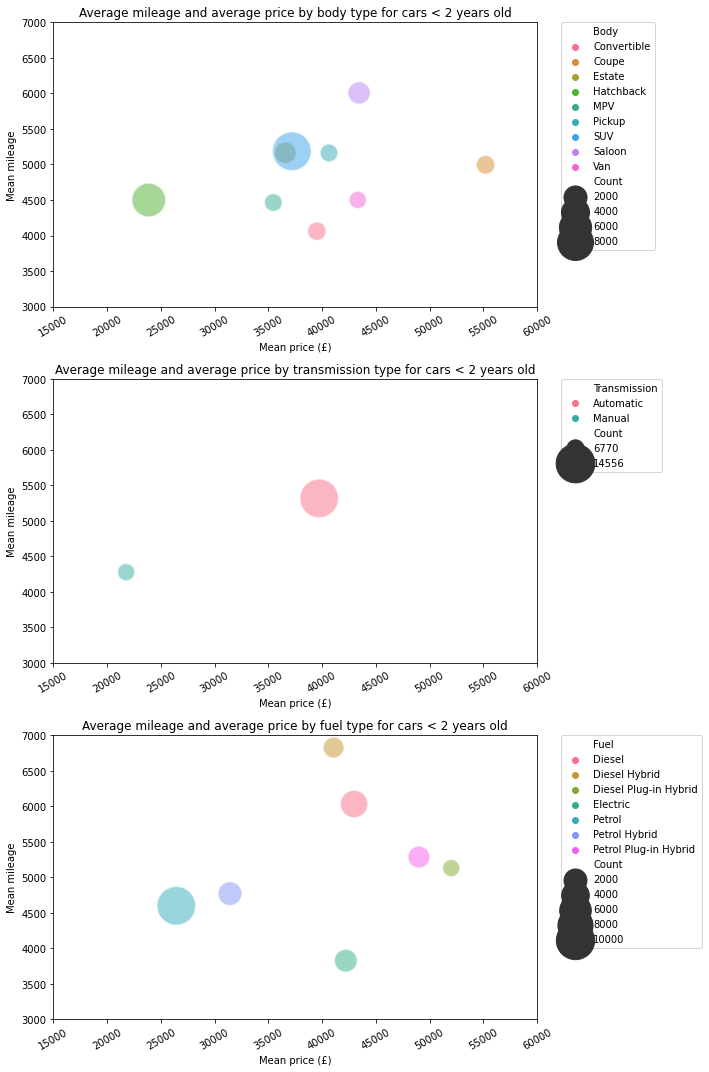

In [92]:
# Plot of avergae price and mileage figures for categorical variables

plotdf1 = df[df.year>2020].groupby(by='fuel')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf1 = plotdf1[plotdf1.fuel!='Bi Fuel']
plotdf1.columns = ['Fuel','price','mileage','Count']
plotdf2 = df[df.year>2020].groupby(by='transmission')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf2.columns = ['Transmission','price','mileage','Count']

plotdf3 = df[df.year>2020].groupby(by='body')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf3.columns = ['Body','price','mileage','Count']

fig, ax = plt.subplots(nrows=3,figsize=(10,15))
sns.scatterplot(data=plotdf1, x="price", y="mileage", hue="Fuel", size='Count',
                sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[2], 
                ).set_title('Average mileage and average price by fuel type for cars < 2 years old')
ax[2].set_xlabel('Mean price (£)')
ax[2].set_ylabel('Mean mileage')
sns.scatterplot(data=plotdf2, x="price", y="mileage", hue="Transmission",
                size='Count',sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[1], 
                ).set_title('Average mileage and average price by transmission type for cars < 2 years old')
ax[1].set_xlabel('Mean price (£)')
ax[1].set_ylabel('Mean mileage')
sns.scatterplot(data=plotdf3, x="price", y="mileage", hue="Body",size='Count',
                sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[0], 
                ).set_title('Average mileage and average price by body type for cars < 2 years old')
ax[0].set_xlabel('Mean price (£)')
ax[0].set_ylabel('Mean mileage')
for i in range(0,3):
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[i].set_ylim(3000,7000)
    ax[i].set_xlim(15000,60000)
    ax[i].tick_params(axis='x', rotation=30)   
plt.tight_layout()
plt.show()

From the top plot where data are divided by car body type:
* Saloons less than 2 years old have run up the most miles, around 6000 on average.
* Hatchbacks less than 2 years old are the cheapest on average of all body types, with Coupe cars being the most expensive.
* SUVs are the most populous used car less than 2 years old on the market.

From the mid plot where data are divided by transmission type:
* Used automatic cars under 2 years old are more common than used manual cars under 2 years old.
* Used automatic cars under 2 years old are more expensive than used manual cars under 2 years old.
* Used automatic cars under 2 years old generally have more miles on them than used manual cars under 2 years old.

From the bottom plot where data are divided by fuel type:
* Used electric cars under 2 years old generally have fewer miles on them than other fuel types. Diesel hybrid cars are the other end of the spectrum. 
* Used petrol cars are the most populous fuel type for cars less than 2 years old.
* Petrol is the cheapest fuel type and Diesel plug-in hybrid cars are the most expensive fuel types for used cars less than 2 years old.

The plot below begins to look at the distribution of car price by each make/brand. This is done for the 16 most popular brands. 

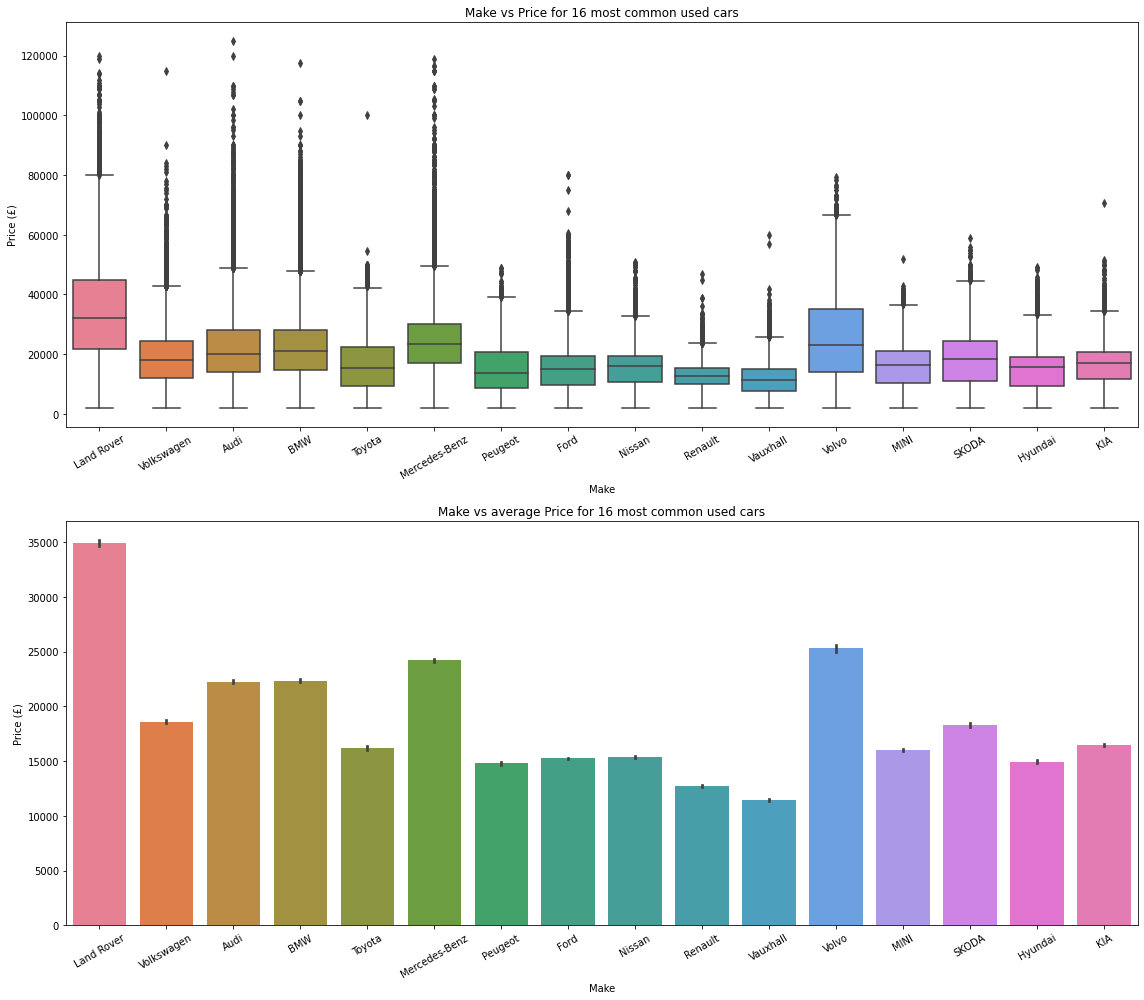

In [93]:
# Plot top 16 car brands - outliers removed in log-space

# Obtain top 16 brands
top16makes = list(df.make.value_counts().head(16).reset_index()['index'])
# Save to a dataframe
plotdf1 = df[df.make.isin(top16makes)]
# Remove outliers from log_price data. Outliers are defined as being outside of 3 standard deviations from the mean.
# There was no major work put into evaluating whether or not this definition is good/true. It could be an area
# for improvement in future if required.
mask = np.abs((plotdf1.log_price - plotdf1.log_price.mean(0))) / plotdf1.log_price.std(0) > 3
plotdf1= plotdf1[~mask]

# Use Seaborn to plot a series of plots.
# Row 1 presents boxplots with a y-axis in terms of price
# Row 2 presents boxplots with a y-axis in terms of log-price
# Row 3 presents barplot of average price with y-axis in terms of price
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,14))
sns.boxplot(x='make', y='price', data=plotdf1, ax=ax[0],palette='husl').set_title('Make vs Price for 16 most common used cars')
ax[0].set_xlabel('Make')
ax[0].set_ylabel('Price (£)')
# sns.boxplot(x='make', y='log_price', data=plotdf1,ax=ax[1],palette='husl').set_title('Make vs Log-Price for 16 most common used cars')
# ax[1].set_xlabel('Make')
# ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="make", y="price", data=plotdf1, ax=ax[1],palette='husl').set_title('Make vs average Price for 16 most common used cars')
ax[1].set_xlabel('Make')
ax[1].set_ylabel('Price (£)')
for i in range(0,2):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

These plots tell the same story in a number of different ways:
* Land Rover, Mercedes-Benz and Volvo stand out as the most expensive brands, with Vauxhall and Renault the cheapest. This can be identified by the average prices in the bottom bar plot or by the median prices in each box plot.
* The skew in the top series of box plots, where the y-axis is in units of price tells of which brands also cater to the high-end car market --> Greater skew means more high performance cars.
    * For each brand, their prime market price range will lie between the 1st and 3rd interquartile ranges.
    * Land Rover, Mercedes-Benz, Audi, and BMW clearly have a greater skew and so also have a high end car offering besides their prime market. The same cannot be said for brands like Mini.

In [94]:
# Checking outlier code. This code can be used to filter on a variable and sort to obtain a printout of the details
# for the most expensive car with that search criteria.

# Unfortunately over time some of the car listings have been removed from AutoTrader, as they sell, so I can't
# always return the listing. Stale data!
f= df[df.make=='Toyota'].sort_values(by='log_price',ascending=False).head(1)
for index, car in f.iterrows():
    print(car)
    print(car[-2])

name                                                  toyota hilux
name_subtitle            3.0 D-4D Invincible Double Cab Pickup 4dr
year                                                          2014
price                                                     100000.0
body                                                        Pickup
mileage                                                   190000.0
BHP                                                          171.0
doors                                                          4dr
transmission                                             Automatic
make                                                        Toyota
fuel                                                        Diesel
mpg                                                        OVER_30
drivertrain                                       Four Wheel Drive
engine                                                         3.0
owners                                                        

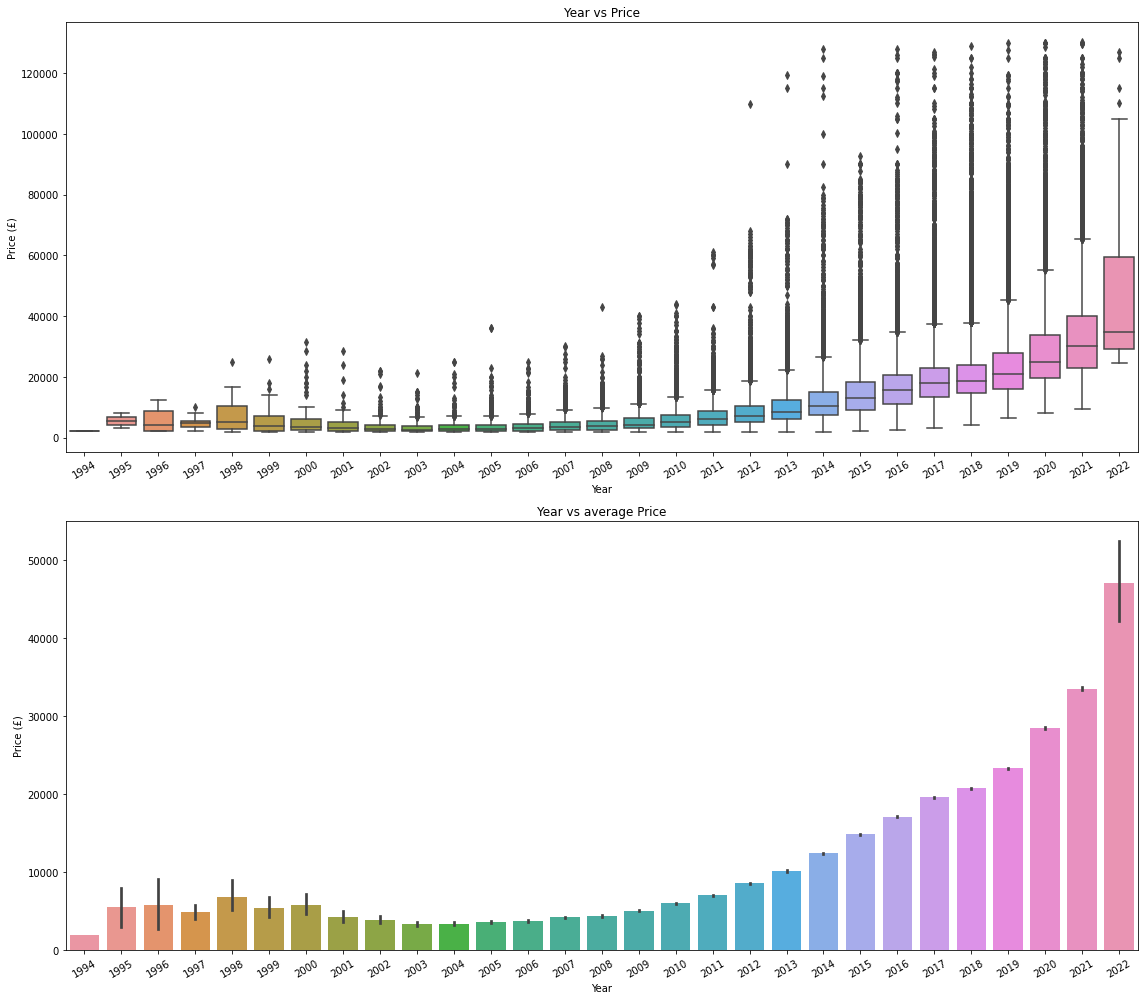

In [95]:
# Plot used car price by year - outliers removed in log-space 

# Remove outliers from log_price data. Outliers are defined as being outside of 3 standard deviations from the mean.
# There was no major work put into evaluating whether or not this definition is good/true. It could be an area
# for improvement in future if required.
mask = np.abs((df.log_price - df.log_price.mean(0))) / df.log_price.std(0) > 3
plotdf2= df[~mask]

# Use Seaborn to plot a series of plots.
# Row 1 presents boxplots with a y-axis in terms of price
# Row 2 presents boxplots with a y-axis in terms of log-price
# Row 3 presents barplot of average price with y-axis in terms of price
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,14))
sns.boxplot(x='year', y='price', data=plotdf2, ax=ax[0]).set_title('Year vs Price')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Price (£)')
# sns.boxplot(x='year', y='log_price', data=plotdf2,ax=ax[1]).set_title('Year vs Log-Price')
# ax[1].set_xlabel('Year')
# ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="year", y="price", data=plotdf2, ax=ax[1]).set_title('Year vs average Price')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Price (£)')
for i in range(0,2):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

These plots describe the relationship between price and age of a car. 
* Price can be seen to decease as the car year approaches 2003, before a slight increase in average price. This must be the vintage car factor being introduced. 
* The relationship between age and price is non-linear. This is already causing alarm bells in terms of lienar regression assumptions.
* Note that confidence bounds (black bar at top of bars in bar plot) are wider for newer cars and older cars as the sample size within each year is greatly reduced. There is a single car from 1994.

This concludes the high-level EDA of the dataset. None of the plots have been particularly surprising. Some of my personal pieces of interest are bulleted below:
* It was interesting to see the non-linear relationship between used car price and age.
* It was interesting to see that used electric vehicles have the least miles on them after two years of use.
* It was interesting to identify the car bands which also offer high-end cars outside of their main market.

From here I'm going to have a look at some of the distributions of the continuous variables in the dataset, and work on justifying some feature selection for the modelling going forward.

## Distribution and collinearity evaluation

The continuous variables in the dataset are price, mileage, BHP, year and engine size. I'm going to look at some distributions and evaluate them for multicollinearity. 

Multicollinearity and the problems associated are explained really nicely in this [link.](https://blog.minitab.com/en/understanding-statistics/handling-multicollinearity-in-regression-analysis)

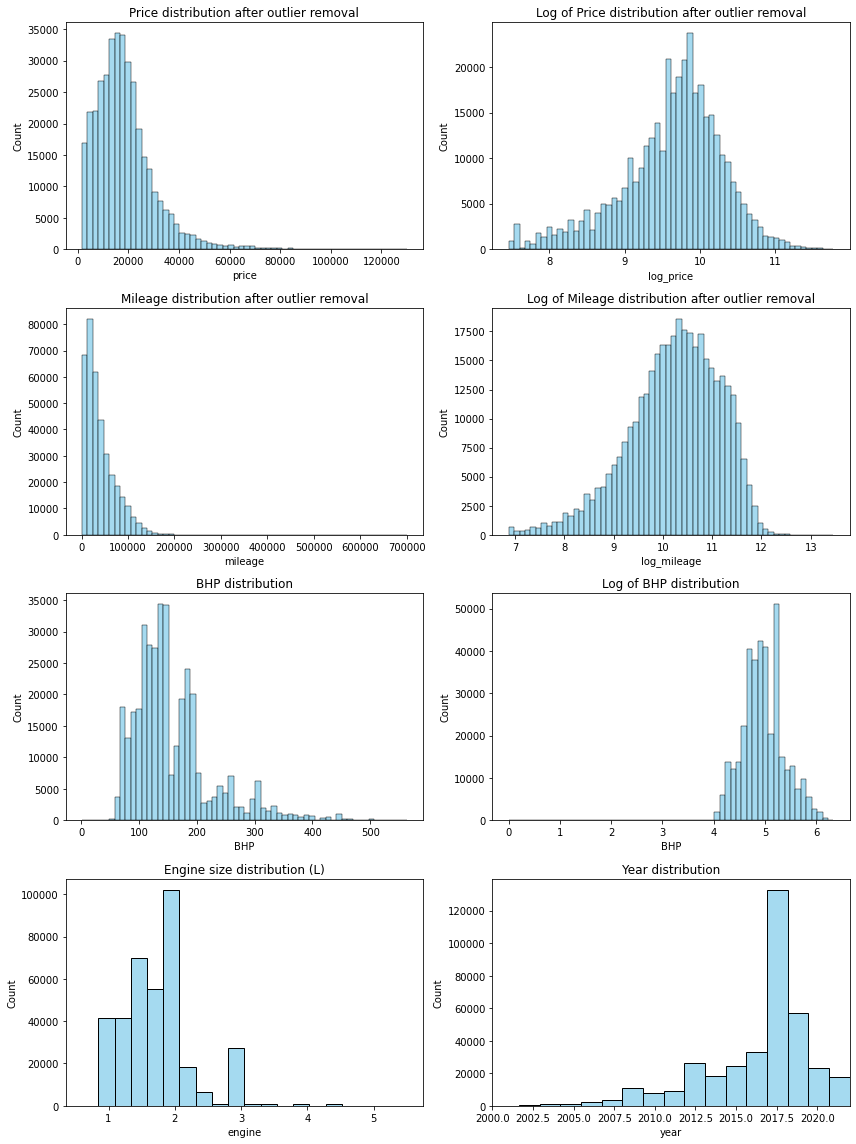

In [96]:
# Seaborn plots of continuous variables

# Remove some outliers from these distributions to observe trends better on the plots below.
mask1 = np.abs((df.log_price - df.log_price.mean())) / df.log_price.std() > 3
dfplot= df[~mask1]
mask2 = np.abs((dfplot.log_mileage - dfplot.log_mileage.mean())) / dfplot.log_mileage.std() > 3
dfplot= dfplot[~mask2]
mask3 = np.abs((dfplot.BHP - dfplot.BHP.mean())) / dfplot.BHP.std() > 6
dfplot= dfplot[~mask3]

# Plot a series of histograms using Seaborn and subplots.
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
sns.histplot(data=dfplot.price, bins=60, color='skyblue',ax=ax[0,0]).set_title('Price distribution after outlier removal')
sns.histplot(data=dfplot.log_price, bins=60, color='skyblue',ax=ax[0,1]).set_title('Log of Price distribution after outlier removal')
sns.histplot(data=dfplot.mileage, bins=60, color='skyblue',ax=ax[1,0]).set_title('Mileage distribution after outlier removal')
sns.histplot(data=dfplot.log_mileage, bins=60, color='skyblue',ax=ax[1,1]).set_title('Log of Mileage distribution after outlier removal')
sns.histplot(data=dfplot.BHP, bins=60, color='skyblue',ax=ax[2,0]).set_title('BHP distribution')
sns.histplot(data=dfplot.BHP.apply(lambda x: np.log(x)), bins=60, color='skyblue',ax=ax[2,1]).set_title('Log of BHP distribution')
sns.histplot(data=dfplot.engine, bins=20, color='skyblue',ax=ax[3,0]).set_title('Engine size distribution (L)')
sns.histplot(data=dfplot.year, bins=22, color='skyblue',ax=ax[3,1]).set_title('Year distribution')
ax[3,1].set_xlim(2000,2022)
plt.tight_layout()
plt.show()

It's clear that none of these continuous variables have a particularly normal distribution. For this reason, although they will be tested, I don't expect linear regression methods to be the best option for modelling within this project.

Taking the log of year, mileage and BHP serves to bring them closer to a normal distribution, with maybe th eexception of BHP. I will used log-price and log-mileage variables in the linear modelling methods. 

Below I have generated some heatmaps of Pearson correlation stats between different variables within the dataset.

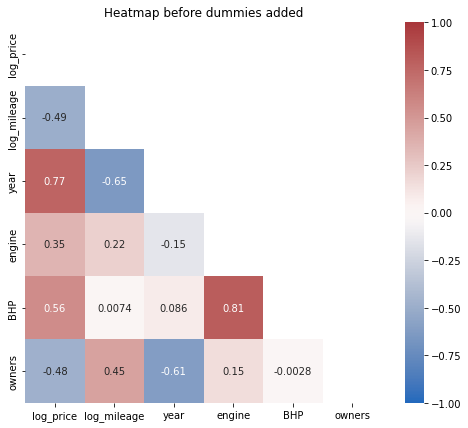

In [97]:
# Heatmap before dummies

# Select variabls I want to compute correlation statistics for
tocorr=['log_price','log_mileage','year','engine','BHP','owners']
plt.rcParams["figure.figsize"] = (8,7)
# Mask the diagonals
mask =np.zeros_like(df[tocorr].corr())
mask[np.triu_indices_from(mask)] = True
# Seaborn used to make the heatmap of the correlation matrix
sns.heatmap(df[tocorr].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, mask=mask)
plt.title('Heatmap before dummies added')
plt.show()

It looks like there's some significant correlation between engine and BHP. I don't want to use highly correlated predictors, and I don't want to venture into Principal Component Analysis (PCA) so I'm going to have to drop one - Engine. 

This is fortunate actually because engine units are inconsistent between electric cars and conventional cars. Teslas don't have 3.0L engines! I will drop the engine column and it won't be used in modelling.

Whilst PCA is a really interesting avenue to go down, it also makes interpretation of the resulting predictors/model much more difficult and would not help with my project objectives.

In [98]:
#Checking for null values 
df[tocorr].isnull().sum()

log_price           0
log_mileage         0
year                0
engine           4740
BHP                 0
owners         181912
dtype: int64

The 4740 null engine values are the electric cars in the dataset.

As well as dropping the engine column, I'm going to have to drop the owners column. This just wasn't populated enough on AutoTrader and has 45% NaN values. I believe that this isn't something I'd be willing to share if the car I was trying to sell had many owners, thus the data, or presence of data, would be biased and highly unreliable anyway. 

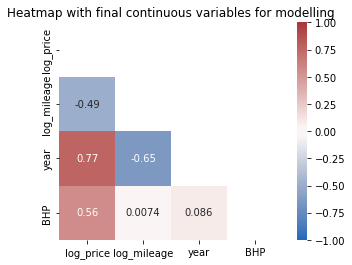

In [99]:
# Heatmap after dropping engine and owners

tocorr=['log_price','log_mileage','year','BHP']
plt.rcParams["figure.figsize"] = (5,4)
mask =np.zeros_like(df[tocorr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df[tocorr].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, mask=mask)
plt.title('Heatmap with final continuous variables for modelling')
plt.show()

Some of these correlation statistics are still quite high, but there are none >0.8 or <-0.8 now so I'll proceed.

Below I assess the Variance Inflation Factor for my remaining continuous variables to evaluate multicollinearity.

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

In [100]:
# Modelling without dummies  - assess VIF 

# Define X and y
X = df[['log_mileage','year','BHP']]

# Great link on multicollinearity
# https://blog.minitab.com/en/understanding-statistics/handling-multicollinearity-in-regression-analysis

# If VIF=1 then there's no multicollinearity
# If VIF>5 then there's significant multicollinearity and it will be a problem

Xvif = add_constant(X)
VIF = pd.Series([variance_inflation_factor(Xvif.values, i) 
               for i in range(Xvif.shape[1])], 
              index=Xvif.columns)
print('VIF stats: \n',VIF,'\n')

VIF stats: 
 const          585118.638545
log_mileage         1.733264
year                1.745992
BHP                 1.014354
dtype: float64 



Since the VIFs are all <5, specifically <2, I conclude that the remaining continuous variables are not overly correlated. This bodes well for model building. 

The continuous variables being progressed to modelling are `price` (target variable),`year`,`BHP` and `mileage`. Note that for the linear models the target variable will be `log_price` and the `log_mileage` will be used.


In [101]:
# Chi2 independence tests have been calculated for categorical variables

# In hindsight, with the domain knowldge that I have, I might be able to just state that I know these categorical
# variables to be independent of each other. 

# Great link on chi2 test for independence https://www.jmp.com/en_be/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html

results=[]
categoricals = ['drivertrain','make','body','transmission','fuel','doors']
for x in itertools.combinations(('drivertrain','make','body','transmission','fuel','doors'), 2):
    categoricalv1 = x[0]
    categoricalv2 = x[1]
    cross_tab = pd.crosstab(df[categoricalv1], df[categoricalv2])
    chi2 = stats.chi2_contingency(cross_tab)
    results.append([x[0],x[1],chi2[0],round(chi2[1],4),chi2[2]])
    chi2df = pd.DataFrame(results, columns = ['categorical1','categorical2','chi2_statistic','p-value','degrees_of_freedom'])  
    
chi2df

,categorical1,categorical2,chi2_statistic,p-value,degrees_of_freedom
0,drivertrain,make,300836.176103,0.0,122
1,drivertrain,body,213636.324160,0.0,16
2,drivertrain,transmission,94245.449378,0.0,2
3,drivertrain,fuel,57479.277298,0.0,14
4,drivertrain,doors,137283.344829,0.0,8
5,make,body,293153.567222,0.0,488
6,make,transmission,108665.291193,0.0,61
7,make,fuel,298334.596129,0.0,427
8,make,doors,206251.379448,0.0,244
9,body,transmission,41010.800991,0.0,8


I'll have to admit that this is hard work for me. I don't use statistics and hypothesis testing frequently enough to be completely comfortable with it, but I'm aware that it can be done, how it can be done and that it can be valuable.

The requirements for a valid chi2 independence test are :
* *Data values that are a simple random sample from the population of interest.*
* *Two categorical or nominal variables. Don't use the independence test with continuous variables that define the category combinations. However, the counts for the combinations of the two categorical variables will be continuous.*
* *For each combination of the levels of the two variables, we need at least five expected values. When we have fewer than five for any one combination, the test results are not reliable.*

These requirements have been met in this circumstance so we can use the test to determine independence of the categorical variables within this project.

For each row in the dataframe above, I understand the null hypothesis to be that 'categorical1 and categorical2 are unrelated'. With the returned p-value of 0.0 each time, I am able to accept the null hypothesis with great confidence, i.e. the categorical variables are indeed unrelated. Hooray!

You may have noticed that I've only computed chi<sup>2</sup> stats for a handful of categorical variables. 

These are the categorical variables that I intend to use in the modelling stage of this project: `fuel`,`doors`,`transmission`,`body`,`make`,`drivetrain`. 

Below is a list of the additional variables in my dataframe, both continuous and categorical, which will not be used in the fist modelling phase, and the associated reason as to why I've chosen not to use them.

* `name` - 1206 unique elements in the name variable but it would require extensive cleaning and is likely captured by other more measurable statistics.
* `name_subtitle` - Free form text box which has been used extensively in data cleaning, now I have all the good information from this unstructured field
* `mpg` - This measurement doesn't translate from conventional to electric vehicles and so has been rejected
* `engine` - This measurement doesn't translate from conventional to electric vehicles and so has been rejected
* `owners` - Not a reliably entered field on AutoTrader.co.uk, better to leave it out
* `ULEZ` - Again, this field is not fully populated and I have little confidence in it as ULEZ is not important to a car dealer in Glasgow (Yet!).
* `dealer_area` - This has been scraped together from the dealer href below. It's not used in the first version of modelling but after some extensive geocoding (see Notebook 3/5) it has been used to obtain Dealer County. This will feature in future work.
* `dealer_city` - This has been scraped together from the dealer href below. It's not used in the first version of modelling but after some extensive geocoding (see Notebook 3/5) it has been used to obtain Dealer County. This will feature in future work.
* `seller1` - Dealer rating was not populated enough to be useful. 
* `e_engine_kW` - This measurement doesn't translate from conventional to electric vehicles and so has been rejected
* `id` - Just a unique identifier from AutoTrader. Not useful in modelling.
* `year_reg` - The information is captured in the year variable.
* `link` - Main purpose is for me to check car listings against the website if they are still on there. Not useful for modelling.
* `href` - This contained the dealer city/area as discussed above. Not useful in modelling.

I think that concludes my distribution and collinearity evaluation. I've confirmed that there is not substantial multicollinearity between the continuous variables, and I've confirmed that there is no substantial multicollinearity between the categorical variables. 

I'm aware that for completeness that I should confirm that there's no multicollinearity between the continuous and categorical variables, but that becomes messy. 
* I've looked into the *Point Biserial* correlation, but opted not to pursue this because only one of my categorical variables (Transmission) is dichotomous. 
* The alternative to the *Point Biserial* correlation is to look at implementing Logistic Regression to understand if there is a relationship between the categorical and the continuous variable. I simply have too many continuous/categorical variables to implement this in my project time frame and so have opted not to. 

This concludes Notebook 4 of 5. 